In [31]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import torch
from torch import vmap
import caustics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
cosmology = caustics.FlatLambdaCDM()
sie = caustics.Point(cosmology=cosmology, name='lens')
# src = caustics.Sersic(name='source')
src = caustics.PointSource(name='source')

In [91]:
n_pix = 100
res = 0.05
upsample_factor = 2
theta_x, theta_y = caustics.utils.meshgrid(
    res / upsample_factor,
    upsample_factor * n_pix,
    dtype=torch.float32,
)

In [92]:
class Microlens(caustics.Simulator):
    def __init__(
            self,
            lens,
            src,
            theta_x=None,
            theta_y=None,
            z_s=None,
            name: str = "sim"
    ):
        super().__init__(name)
        self.lens = lens
        self.src = src

        self.add_param("theta_x", theta_x)
        self.add_param('theta_y', theta_y)
        self.add_param("z_s", z_s)


    def forward(self, params):
        theta_x, theta_y, z_s = self.unpack(params)
        beta_x, beta_y = self.lens.raytrace(theta_x, theta_y, z_s, params)
        baseline_brightness = self.src.brightness(theta_x, theta_y, params)
        brightness = self.src.brightness(beta_x, beta_y, params)
        return brightness.mean()/baseline_brightness.mean()

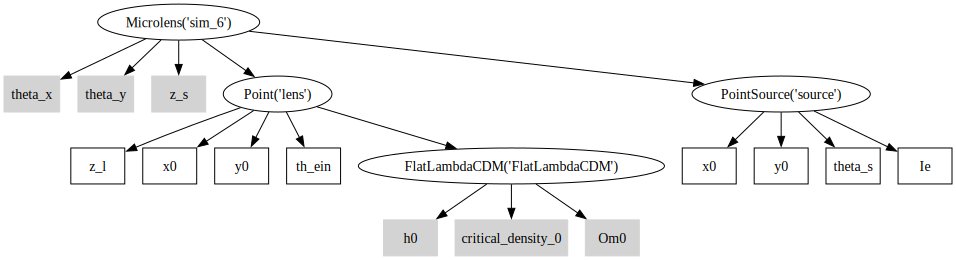

In [93]:
sim = Microlens(sie, src, theta_x=theta_x, theta_y=theta_y, z_s=0.5)
sim.graph(True,True)

In [94]:
sim.x_order

['lens.z_l',
 'lens.x0',
 'lens.y0',
 'lens.th_ein',
 'source.x0',
 'source.y0',
 'source.theta_s',
 'source.Ie']

In [109]:
# x = torch.tensor([
#     #    z_l  x0   y0  th_ein x0   y0   q   phi   n   Re   Ie
#          0.1, 0.0, 0.0, 0.5, 0.0, 0.0, 1.0, 0.0, 1.3, 1.0, 5.0
#     ])  

# x = torch.tensor([ 
#     #    z_l  x0   y0  th_ein x0   y0   q   phi   n   Re   Ie
#          0.1, 0.0, 0.0, 0.5, 0.0, 0.0, 1.0, 0.0, 1.3, 0.01, 5.0
#     ])  

x = torch.tensor([
    #    z_l  x0   y0  th_ein x0   y0  theta_s, Ie
         0.1, 0.0, 0.0, 0.5, 0.0, 0.0, 2.1,    5.0
    ])  

In [110]:
sim(x)

tensor(1.1077)

In [111]:
B=21 #Batch size
newx = x.repeat(B, 1)
x0s = torch.linspace(-5, 5, B).view(-1, 1)  # Shape is [B, 1]
y0s = torch.zeros_like(x0s)
newx[:,1] = x0s.view(-1)
newx[:,2] = y0s.view(-1)
ts = torch.linspace(-1,1,B).view(-1,1) #Create dummy time variables

In [112]:
ys = vmap(sim)(newx)

In [113]:
def pspl_mag(u):
    return (u**2 + 2)/(u*(u**2 + 4)**(1/2))

In [114]:
us = (x0s**2 + y0s**2)**(1/2)
pspl_mags = pspl_mag(us)

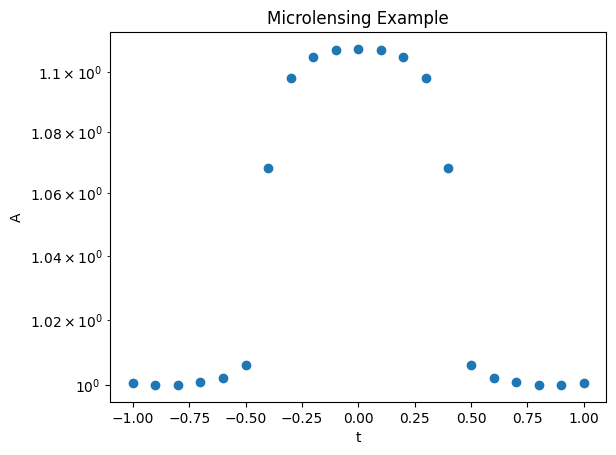

In [115]:
plt.scatter(ts, ys)
# plt.plot(ts, pspl_mags)

plt.yscale('log')
plt.xlabel('t')
plt.ylabel('A')
plt.title('Microlensing Example')

plt.show()